# Comparison: RandomForest with Oversampling vs Augmented Data

In this blog I'd like to show the difference deep tabular augmentation can have when training a Random Forest on a highly biased data base. In this case, we have a look at credit card fraud, where fraud itself is is way less represented than non-fraud. 

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
import mlprepare as mlp
import deep_tabular_augmentation as dta
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_PATH = 'data/creditcard.csv'

df = pd.read_csv(DATA_PATH)

Let's have a short look at the data:

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Also, let's have a look of how many more non-fraud cases we have compared to fraud cases:

In [4]:
difference_in_class_occurences = df['Class'].value_counts()[0]-df['Class'].value_counts()[1]
difference_in_class_occurences

283823

In order to make use of the deep tabular augmentation we need to scale the data and then use only those cases, in which class we are interested in, in this case "Class" is equal to 1.

In [5]:
X_train, X_test, y_train, y_test = mlp.split_df(df, dep_var='Class', test_size=0.3, split_mode='random')

x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)

X_test_scaled = x_scaler.transform(X_test)

X_train_fraud = X_train_scaled[np.where(y_train==1)[0]]
X_test_fraud = X_test_scaled[np.where(y_test==1)[0]]

For our model to work we need to put our data in a DataLoader (here I use the DataBunch Class from deep data augmentation).

In [6]:
datasets = dta.create_datasets(X_train_fraud, y_train.values[np.where(y_train==1)], X_test_fraud, y_test.values[np.where(y_test==1)])
data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024))

Now we're already good to go. We can define our Variational Encoder Architecture (here: 50->12->12->5->12->12->50) and then use the LearningRate Finder to tell us the best Learning rate:

In [7]:
D_in = X_train_fraud.shape[1]
VAE_arch = [50, 12, 12]
target_name = 'Class'
target_class = 1
df_cols = list(df.columns)

model = dta.Autoencoder(D_in, VAE_arch, latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = dta.customLoss()

In [8]:
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)

run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])

run.fit(100, learn)

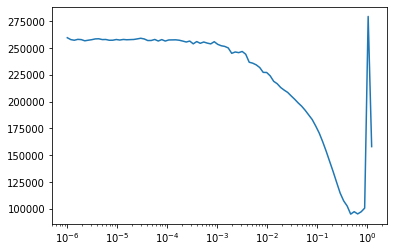

In [9]:
run.recorder.plot(skip_last=5)

We set up a desirable learning rate and scheduler for our learning rate:

In [10]:
sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.1), dta.sched_cos(0.1, 0.01)])

Now, let's train the model:

In [11]:
cbfs = [partial(dta.LossTracker, show_every=50), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
model = dta.Autoencoder(D_in, VAE_arch, latent_dim=20).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)
run = dta.Runner(cb_funcs=cbfs)
run.fit(400, learn)

epoch: 50
train loss is: 260695.875
validation loss is: 81048.234375
epoch: 100
train loss is: 189985.546875
validation loss is: 60324.9609375
epoch: 150
train loss is: 136012.046875
validation loss is: 875778.875
epoch: 200
train loss is: 101500.59375
validation loss is: 2181067.75
epoch: 250
train loss is: 81021.46875
validation loss is: 1641556.0
epoch: 300
train loss is: 67821.7421875
validation loss is: 1316295.625
epoch: 350
train loss is: 58849.52734375
validation loss is: 1098919.125
epoch: 400
train loss is: 52371.15625
validation loss is: 943453.25


Let's see how the created data looks like:

In [13]:
df_fake = run.predict_df(learn, no_samples=difference_in_class_occurences, scaler=x_scaler)
std_list = list(df[df['Class']==1][df_cols].std())
df_fake_with_noise = run.predict_with_noise_df(learn, no_samples=difference_in_class_occurences, mu=0, sigma=std_list, scaler=x_scaler)
df_fake_with_noise.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,74522.773438,-2.734601,1.005523,-2.757621,2.059611,-1.897208,-0.624007,-2.928258,0.020250,-1.309305,...,0.411411,0.489351,-0.187566,-0.093161,-0.180062,-0.021390,0.429580,-0.112336,174.301636,1
1,71122.085938,-3.364894,1.113367,-2.830953,1.941989,-2.211236,-0.474092,-3.311430,-0.250421,-1.296847,...,0.530714,0.576042,-0.143654,-0.127971,-0.212887,-0.050346,0.267594,-0.196522,152.549332,1
2,72262.554688,-3.067988,0.994937,-2.702702,1.932057,-2.033894,-0.515574,-3.079490,-0.199522,-1.262724,...,0.414692,0.561618,-0.165115,-0.111071,-0.198514,-0.028727,0.338351,-0.172759,165.774490,1
3,73973.804688,-2.787799,1.106817,-2.899842,2.136128,-1.973441,-0.626688,-3.118646,0.066192,-1.401460,...,0.510039,0.485301,-0.177926,-0.132326,-0.191207,-0.027750,0.489111,-0.112897,167.713379,1
4,71257.742188,-3.663607,1.053864,-2.765614,1.807425,-2.234919,-0.426937,-3.167879,-0.426527,-1.141452,...,0.389872,0.609650,-0.141396,-0.074850,-0.199298,-0.034171,0.015338,-0.238806,150.548233,1


In [14]:
df_fake_with_noise.describe().loc[['mean']]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
mean,75590.023438,-2.798141,1.225208,-3.052627,2.222055,-1.998127,-0.654141,-3.215112,0.090021,-1.45585,...,0.600387,0.459203,-0.170964,-0.144605,-0.177815,-0.03288,0.479426,-0.091728,161.561417,1.0


## Train Random Forest

We want to compare how the built-in class_weight functionality performs vs the new approach (spoiler: if you do not use any weights the RandomForest will always predict 0). Hence, we create three dataframes: the original, the original appended with fake_data, the original appended with fake data with noise.

In [15]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
train_df_fake = pd.concat([train_df, df_fake])
train_df_fake_with_noise = pd.concat([train_df, df_fake_with_noise])

To make things easier to understand, let's define the datasets on which to train and on which to assess the results:

In [16]:
X_train, X_test, X_train_aug = train_df.iloc[:,:30].values, test_df.iloc[:,:30].values, train_df_fake_with_noise.iloc[:,:30].values
y_train, y_test, y_train_aug = train_df.iloc[:,30].values, test_df.iloc[:,30].values, train_df_fake_with_noise.iloc[:,30].values

First, let's train model on the original data while using the differences in class occurences as weights.

In [17]:
def rf(xs, y, n_estimators=40, max_samples=500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True, class_weight={0:1,1:difference_in_class_occurences}).fit(xs, y)

In [18]:
m = rf(X_train, y_train)
confusion_matrix(y_test, np.round(m.predict(X_test)))

array([[85295,    12],
       [  104,    32]])

Then, we use the augmented dataframe:

In [19]:
def rf_aug(xs, y, n_estimators=40, max_samples=500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [20]:
m_aug = rf_aug(X_train_aug, y_train_aug)
confusion_matrix(test_df.iloc[:,30].values, np.round(m_aug.predict(test_df.iloc[:,:30].values)))

array([[85291,    16],
       [   48,    88]])

Wow, I think that is quite astonishing. We managed to highly increase the number of fraud cases we are able to detect. Moreover, we achieved these results without any finetuning of the model architecture and simply using the default structure of the VAE. 

I hope this blog shed some light on why using this approach on highly biased data is worth a shot trying.

Lasse